In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import operator
import ast
from tqdm import tqdm

# For importing functions
import ipynb
import sys  

# Import data
sys.path.insert(0, 'C:/Users/Owner/Documents/Thesis/Code/Season_Analysis/Extraction_Partitioning_Functions')

from ipynb.fs.full.Data_Extraction_Functions import three_month_extraction,five_month_extraction,extract_region_lists
# Import partitioning functions
from ipynb.fs.full.Partitioning_Functions import regional_ordinal_sequence,block_ordinal_sequence

sys.path.insert(0,'C:/Users/Owner/Documents/Thesis/Code/Season_Analysis/Proxy_Permutation_Entropy')
from ipynb.fs.full.Proxy_Permutation_Entropy_Functions import permutation_tree, kinda_entropy

sys.path.insert(0,'C:/Users/Owner/Documents/Thesis/Code/Season_Analysis/Co_Occurrence')
from ipynb.fs.full.Co_Occurrence_Functions import derived_coupling_strength, ordpat_strings

# Import Data

In [2]:
## Import data

three_month = extract_region_lists(three_month=True)
djf_dates = three_month[0]
jja_dates = three_month[1]
three_monthly = three_month[2:]

five_month = extract_region_lists(three_month=False)
ndjfm_dates = five_month[0]
mjjas_dates = five_month[1]
five_monthly = five_month[2:]

names = ['NWAus', 'NEAus', 'MC', 'IO', 'EEP', 'ISM', 'EASM']
regions = [i for i in range(7)]

DJF/JJA Order: DJF_dates,JJA_dates,nw,ne,mc,ioo,eep,ism,easm
Length of time series with minor temporal irregularities: 753
Number of missing months: 21
Length of time series with no temporal irregularities: 720
NDJFM/MJJAS Order: NDJFM_dates,MJJAS_dates,nw,ne,mc,ioo,eep,ism,easm


In [3]:
permutation_names = []
for i,j in itertools.combinations(regions,2):
    string = f'{names[i]} & {names[j]}'
    permutation_names.append(string)

In [4]:
years_3 = []
for i in range(len(djf_dates)):
    date = djf_dates[i]
    year = date[-4:]
    years_3.append(year)

In [5]:
years_plot = years_3[::3]

In [6]:
years = []
for i in range(len(ndjfm_dates)):
    date = ndjfm_dates[i]
    year = date[-4:]
    years.append(year)

# Generate Ordinal Sequences

In [7]:
patterns_3 = ordpat_strings(three_monthly,3,1,block=True)
patterns_5 = ordpat_strings(five_monthly,5,1,block=True)

Order: NW_Aus, NE_Aus, MC, IO, EEP, ISM, EASM
Order: NW_Aus, NE_Aus, MC, IO, EEP, ISM, EASM


# Define Co-Occurrence Functions

In [8]:
def co_occur(region1,region2):
    N = len(region1) # Since length of all ordinal sequences are the same 
    
    co_occur_join = []
    for i in range(N):
        #joined = region1[i] + region2[i]
        joined = (region1[i],region2[i])
        co_occur_join.append(joined)
    
    return co_occur_join


def count_frequency(input_list,highest_freq=True):
    '''
    Count frequency of each unique element in input_list
    '''
    freq = {} # Create empty dictionary
    for item in input_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    if highest_freq==True:
        return dict(sorted(freq.items(),key = operator.itemgetter(1),reverse=True))
    else:
        return freq

def co_occur_frequency(region1,region2,pattern_length,greater_than_value,show_zero=False):
    '''
    Find how each pattern in the ordinal sequence of region1 is distributed amonst the co-occurrences in region2
    
    Inputs:
        region1 = ordinal sequence for first region
        region2 = ordinal sequence for second region
        pattern_length = length of the ordinal pattern of interest
        greater_than_value = filter dictionary by co-occurrence greater than or equal to this value
        show_zero = True -> show all (pattern_lenth!)**2 pattterns including those which occur 0 times
                    False ->  only show patterns which occur >0 times
        
    Returns:
        List of dictionaries with distribution of each ordinal pattern co-occurrence
    '''
    admissible = [''.join(str(list(i)).split(',')) for i in  list(itertools.permutations([i for i in range(pattern_length)]))]
    admissible_co_occurrences = list(itertools.product(admissible, repeat=2))
    
    test = co_occur(region1, region2)
    freqs = count_frequency(test)
    
    if show_zero==False:
        filtered_dict = {k: v for (k,v) in freqs.items() if v >= greater_than_value}
        return filtered_dict
    else:
        for i in range(len(admissible_co_occurrences)):
            potential = admissible_co_occurrences[i]
            if potential not in freqs.keys():
                freqs[potential] = 0
        return sorted(freqs.items()) 
    
def chunked_ord_seq(ordinal_sequence_region_1,
                    ordinal_sequence_region_2,
                    window_length,
                    block_length,
                    co_occurring_threshold=1):
    '''
    Calculate the number of co-occurring patterns. Note the assumpt
    
    Inputs:
        1) ordinal_sequence_region_1 = ordinal sequence corresponding to region 1 (the result of regional_ordinal_sequence() or block_ordinal_sequence())
        2) ordinal_sequence_region_2 = ordinal sequence corresponding to region 2
        3) window_length = ordinal partition window length, D corresponding to the sequence above
        4) co_occurrence_threshold = threshold for a co-occurring pattern to be prescribed, default = 1
        5) block_length = length of the sub-sample of ordinal sequence to derive coupling strength temporally
    '''
    region_1_split = []
    region_2_split = []
    for i in range(len(ordinal_sequence_region_1)): ## TO DO: FIND GENERAL FORM FOR THE LENGTH OF THE ADMISSIBLE PATTERN
        lower_bound = i
        upper_bound = i+block_length
        
        chain_1 = ordinal_sequence_region_1[lower_bound:upper_bound]
        chain_2 = ordinal_sequence_region_2[lower_bound:upper_bound]
        
        if len(chain_1)==len(chain_2) == block_length:
            region_1_split.append(list(chain_1))
            region_2_split.append(list(chain_2))
        else:
            break
    return np.asarray(region_1_split),np.asarray(region_2_split)

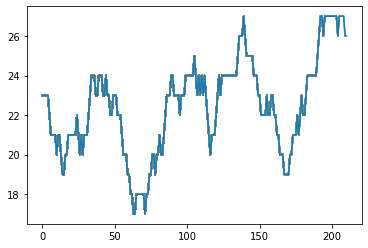

In [9]:
test = chunked_ord_seq(patterns_5[0],patterns_5[1],5,30)
aa = []
for i in range(len(test[0])):
    ting = len(co_occur_frequency(test[0][i],test[1][i],5,1))
    aa.append(ting)
    plt.plot(aa)

# Define Simpler PE Difference Measure

In [10]:
def return_order(original,permutation):
    all_permutations = permutation_tree(original)
    order = all_permutations[str(permutation)] 
    
    return order

In [75]:
return_order([0,1,2,3],[3,2,1,0])

6

### Explore how the difference in patterns progresses 

In [11]:
aaa = np.zeros((21,len(patterns_5[0])))
z = 0
for i,j in itertools.combinations(regions,2):
    co_occurring = co_occur(patterns_5[i],patterns_5[j])
    
    for k in tqdm(range(len(co_occurring))):
        starting = ast.literal_eval(str(co_occurring[k][0]).replace(' ',','))
        comparing = ast.literal_eval(str(co_occurring[k][1]).replace(' ',','))
        
        score = return_order(starting,comparing)
        aaa[z][k] = score
    z+= 1

permutations = list(permutation_tree([0,1,2,3,4]).keys())

test_5_scores = {}
for i in range(len(permutations)):
    score = return_order([0,1,2,3,4],permutations[i])
    test_5_scores[permutations[i]]=score

horizontal_bound_5 = sorted(list(set(test_5_scores.values())))

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:03<00:00, 61.88it/s]


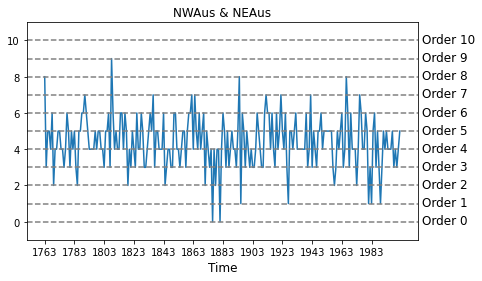

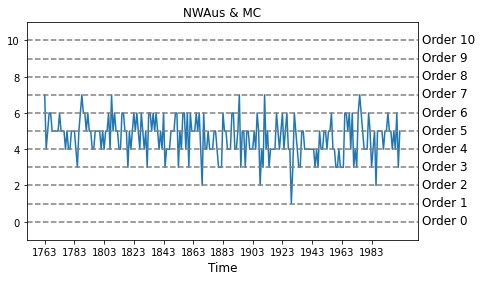

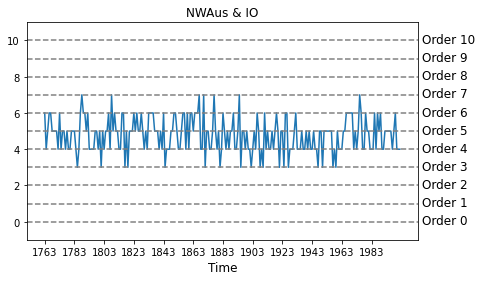

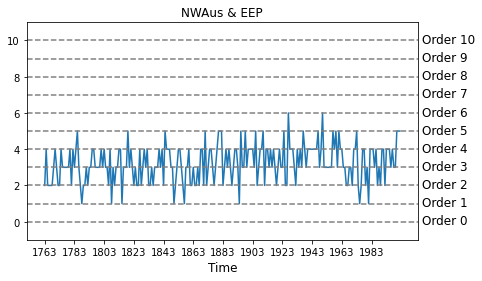

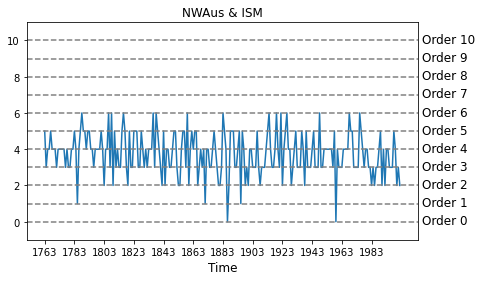

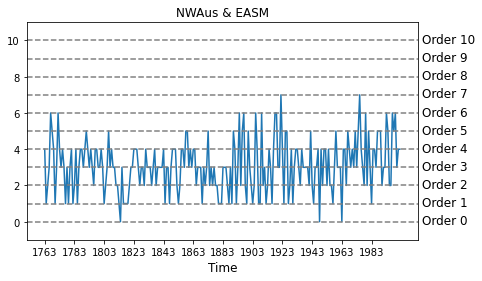

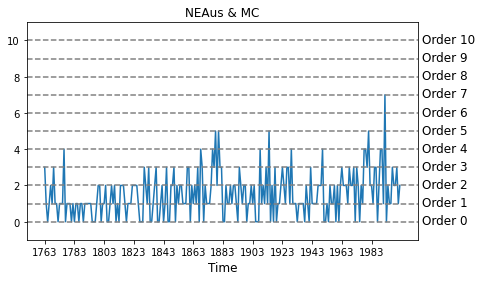

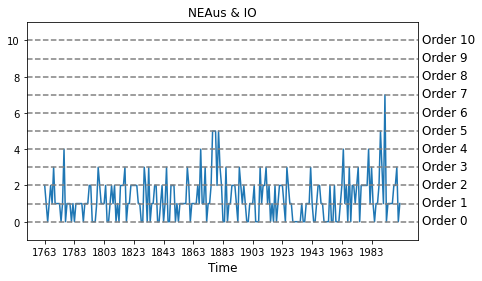

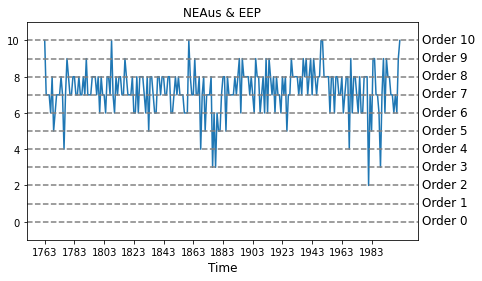

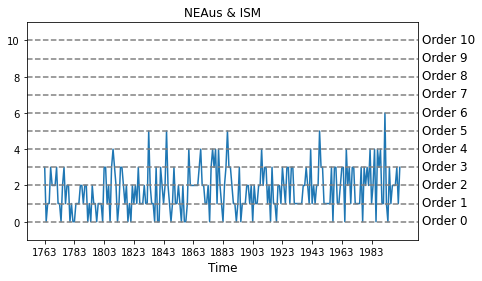

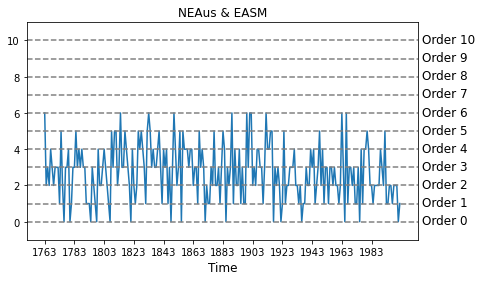

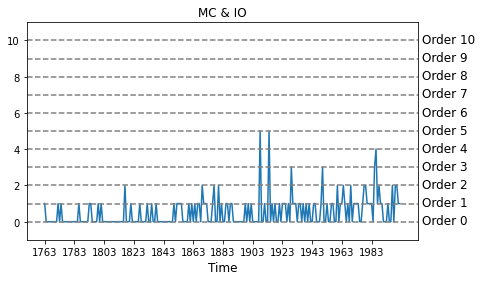

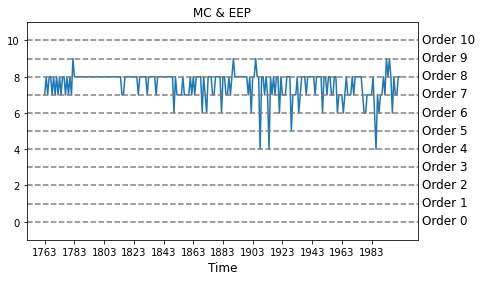

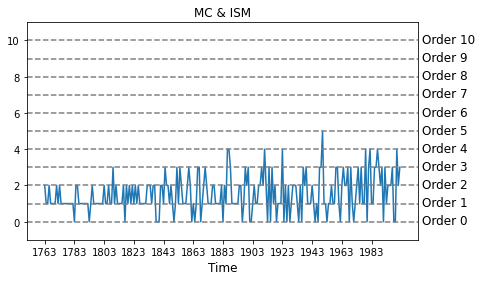

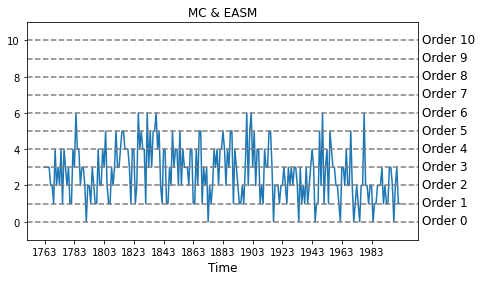

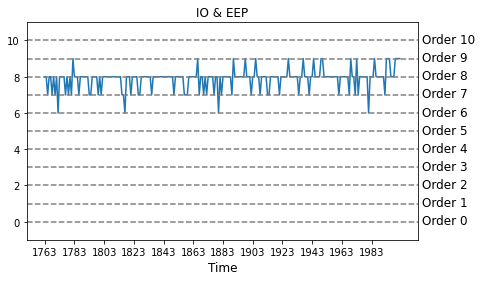

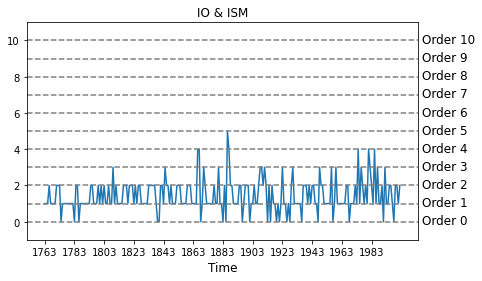

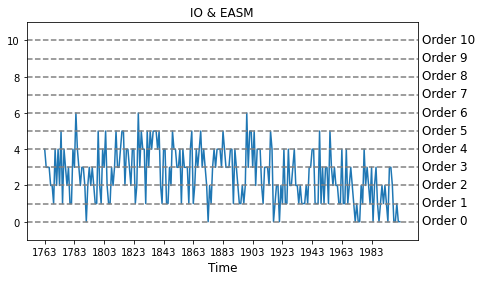

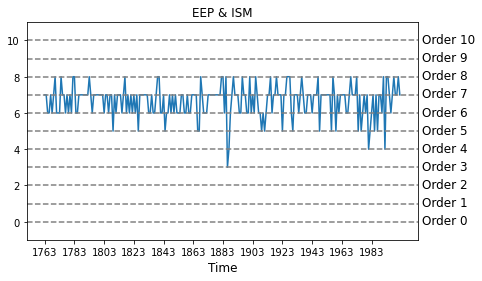

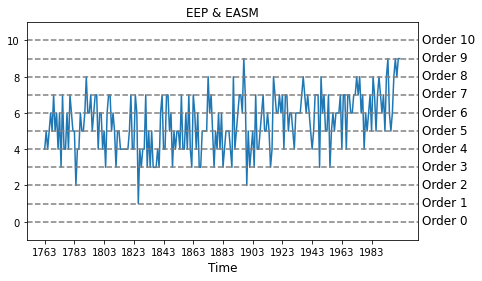

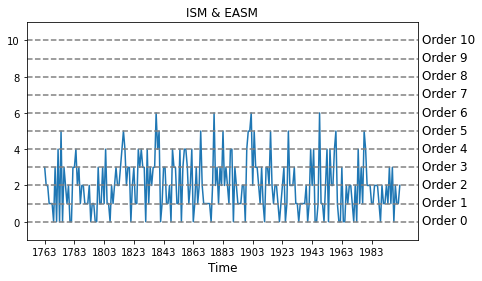

In [42]:
for i in range(len(aaa)):
    plt.figure(figsize=(7,4))
    plt.plot(years[::5],aaa[i])
    plt.title(permutation_names[i])
    plt.xlabel('Time', fontsize=12)
    plt.xticks(years[::5][::20])
    plt.ylim((-1,11))
    [plt.axhline(y=horizontal_bound_5[i],linestyle='--',c='grey') for i in range(len(horizontal_bound_5))]
    [plt.text(years.index(years[-1])-943,horizontal_bound_5[i]-0.15,f'Order {i}', fontsize=12) for i in range(len(horizontal_bound_5))]
    plt.show()

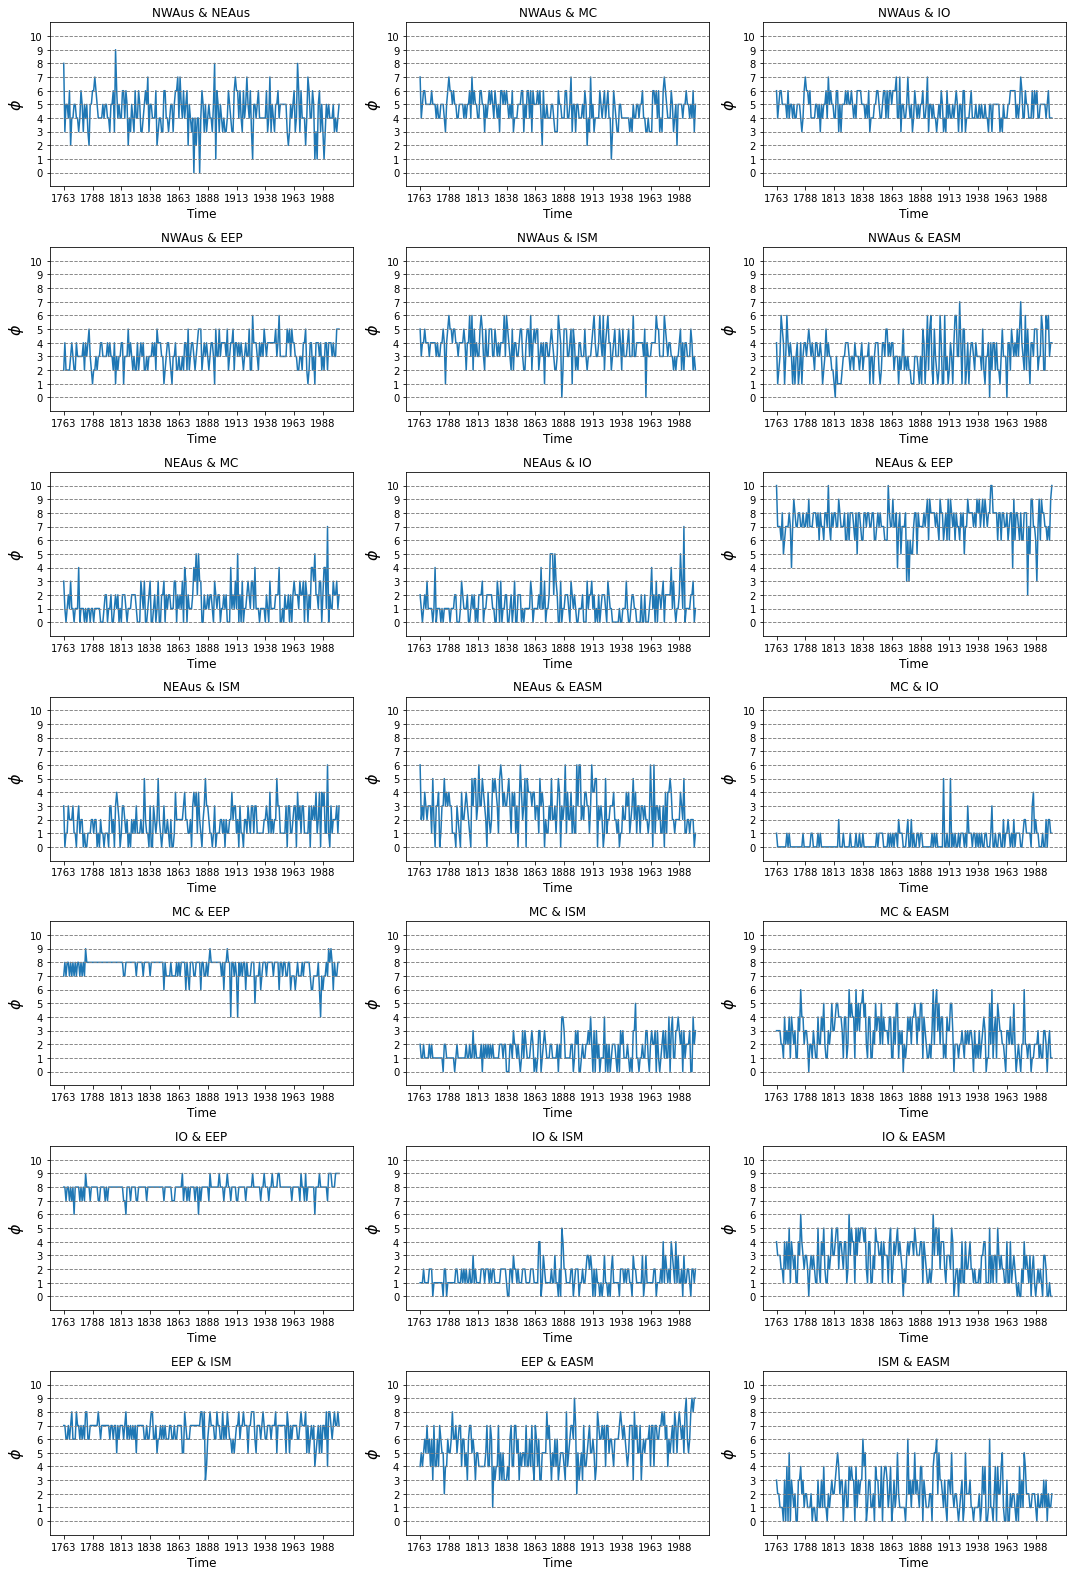

In [54]:
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15,22))
axs = axs.ravel()
for i in range(len(aaa)):
    axs[i].plot(years[::5],aaa[i])
    axs[i].set_ylabel(r'$\phi$', fontsize=16)
    axs[i].set_xlabel('Time', fontsize=12)
    axs[i].set_xticks(years[::5][::25])
    axs[i].set_yticks([i for i in range(0,11)])
    axs[i].set_title(permutation_names[i])
    axs[i].set_ylim((-1,11))
    [axs[i].axhline(y=horizontal_bound_5[j],linestyle='--',c='grey',linewidth=0.9) for j in range(len(horizontal_bound_5))]
    #[plt.text(years.index(years[-1])-943,horizontal_bound_5[i]-0.15,f'Order {i}', fontsize=12) for i in range(len(horizontal_bound_5))]       

fig.tight_layout()

In [36]:
five_orders = list(permutation_tree([0,1,2,3,4]).values())
count_frequency(five_orders,False)

{0: 1, 1: 4, 2: 9, 3: 15, 4: 20, 5: 22, 6: 20, 7: 15, 8: 9, 9: 4, 10: 1}

In [37]:
def order_filtered_co_occur(ordinal_sequence_region1,ordinal_sequence_region2,window_length,co_occur_threshold,cutoff_order):
    #test_dict = co_occur_frequency(patterns_5[0],patterns_5[1],window_length,co_occur_threshold)
    test_dict = co_occur_frequency(ordinal_sequence_region1,
                                   ordinal_sequence_region2,
                                   window_length,
                                   co_occur_threshold)
    #test_dict = count_frequency(co_occur(test_region1, test_region2))
    
    test_keys = list(test_dict.keys())
    test_values = list(test_dict.values())
    
    #co_occurring_patterns_of_order = 0
    #for i in range(len(test_keys)):
    #    starting_pattern = ast.literal_eval(str(test_keys[i][0]).replace(' ',','))
    #    compare_value = ast.literal_eval(str(test_keys[i][1]).replace(' ',','))
    #    
    #    order_difference = return_order(starting_pattern,compare_value)
    #    
    #    if order_difference == cutoff_order:
    #        co_occurring_patterns_of_order += 1
    #    else:
    #        pass
    #    
    #return co_occurring_patterns_of_order
    #print(f'Order {cutoff_order} Permutations:')
    co_occurring_patterns_of_order = 0
    for i in range(len(test_keys)):
        starting_pattern = ast.literal_eval(str(test_keys[i][0]).replace(' ',','))
        compare_value = ast.literal_eval(str(test_keys[i][1]).replace(' ',','))
        
        order_difference = return_order(starting_pattern,compare_value)
        
        if order_difference == cutoff_order:
            co_occurring_patterns_of_order += 1
            #print(starting_pattern,compare_value)
        else:
            pass
        
    return co_occurring_patterns_of_order

###  Explore an example of how ALL co-occurrences are distributed between region pairs 

By using the entire length of the ordinal sequence for each region, this is an exercise to see how different co-occurring patterns between regions are.

For example, does only an order 4 or above change occur between Region X and Y? Or are there periods where there is an order 0 change?

#### Pattern Length 3 

In [38]:
order_diff_distribution = []
for i,j in itertools.combinations(regions,2):
    orders = [i for i in range(0,3+1)]
    
    freqs = []
    for k in tqdm(range(len(orders))):
        frequency = order_filtered_co_occur(patterns_3[i],patterns_3[j],3,1,orders[k])
        freqs.append(frequency)
    order_diff_distribution.append(freqs)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 192.86it/s]


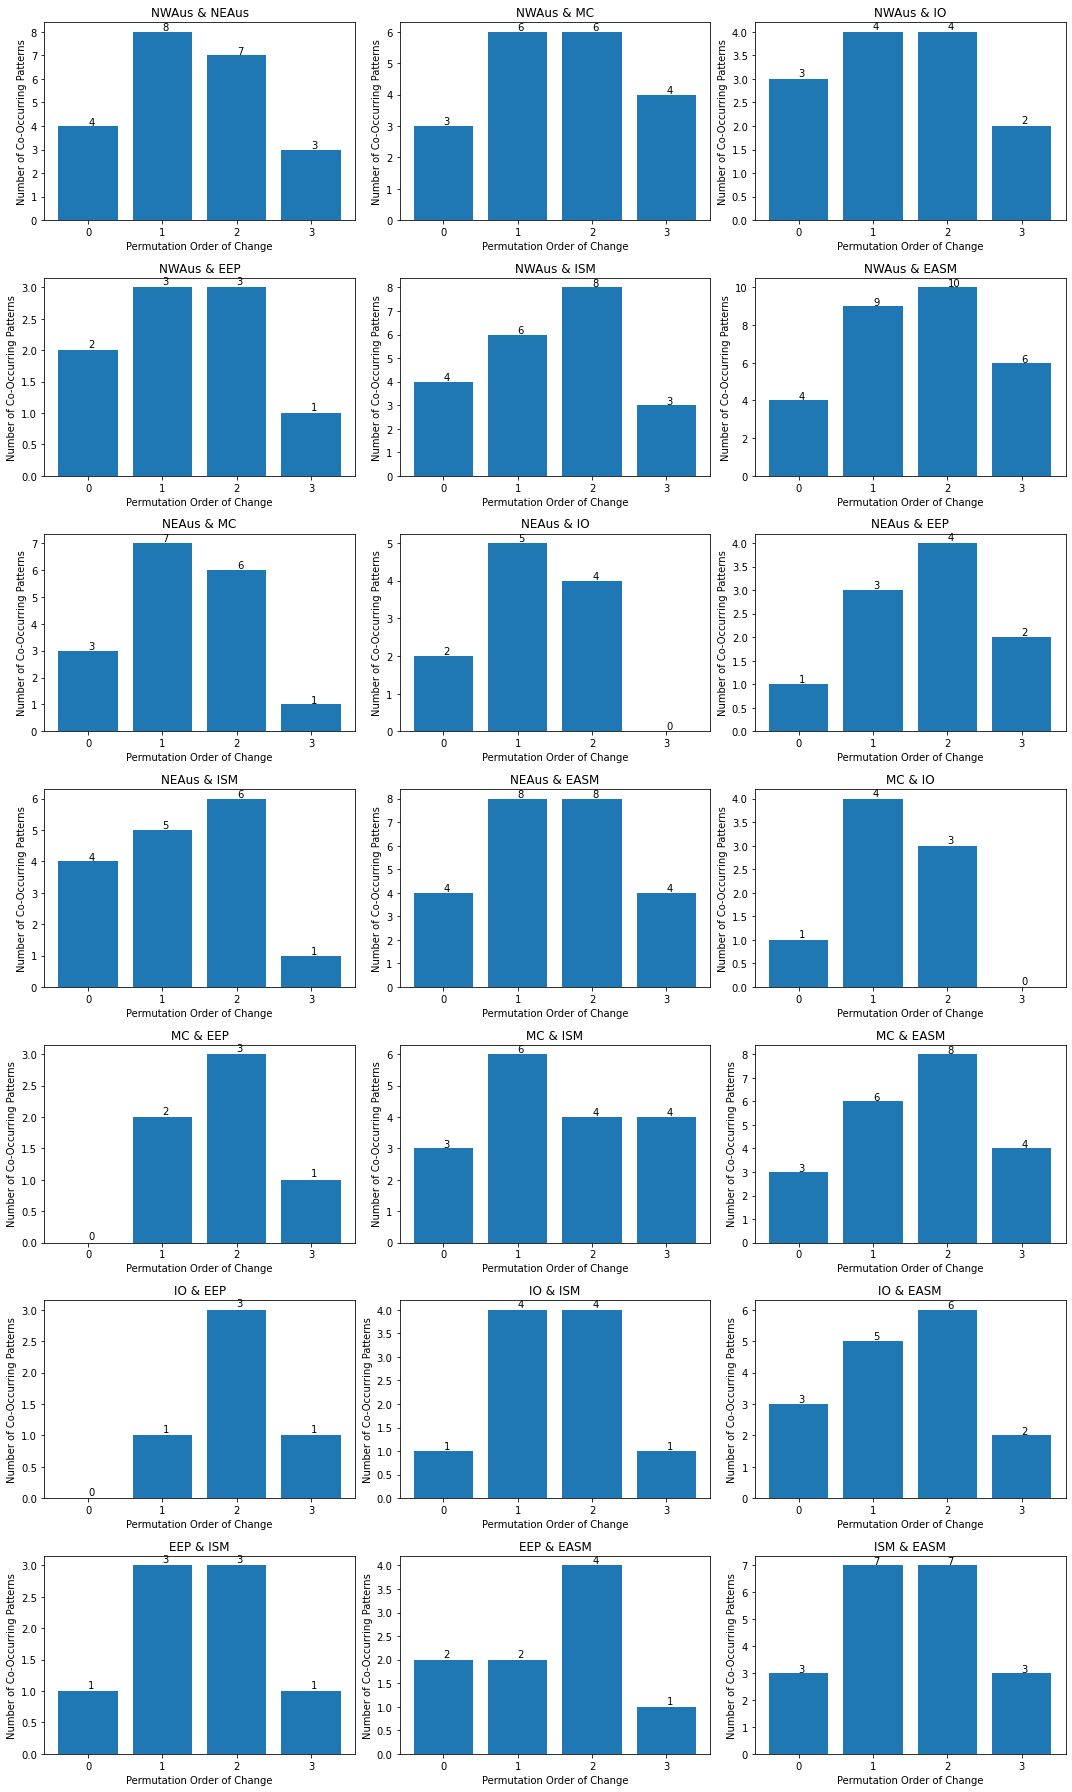

In [39]:
orders = [i for i in range(0,3+1)]

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15,25))
axs = axs.ravel()
for i in range(len(order_diff_distribution)):
    axs[i].bar(orders,order_diff_distribution[i],tick_label=orders)
    axs[i].set_ylabel('Number of Co-Occurring Patterns')
    axs[i].set_xlabel('Permutation Order of Change')
    axs[i].set_title(permutation_names[i])
    for j, v in enumerate(order_diff_distribution[i]):
        axs[i].text(orders[j], v + 0.05, str(v))
    
fig.tight_layout()

#### Pattern Length 5 

In [40]:
order_diff_distribution = []
for i,j in itertools.combinations(regions,2):
    orders = [i for i in range(0,11)]
    
    freqs = []
    for k in tqdm(range(len(orders))):
        frequency = order_filtered_co_occur(patterns_5[i],patterns_5[j],5,1,orders[k])
        freqs.append(frequency)
    order_diff_distribution.append(freqs)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.41s/it]


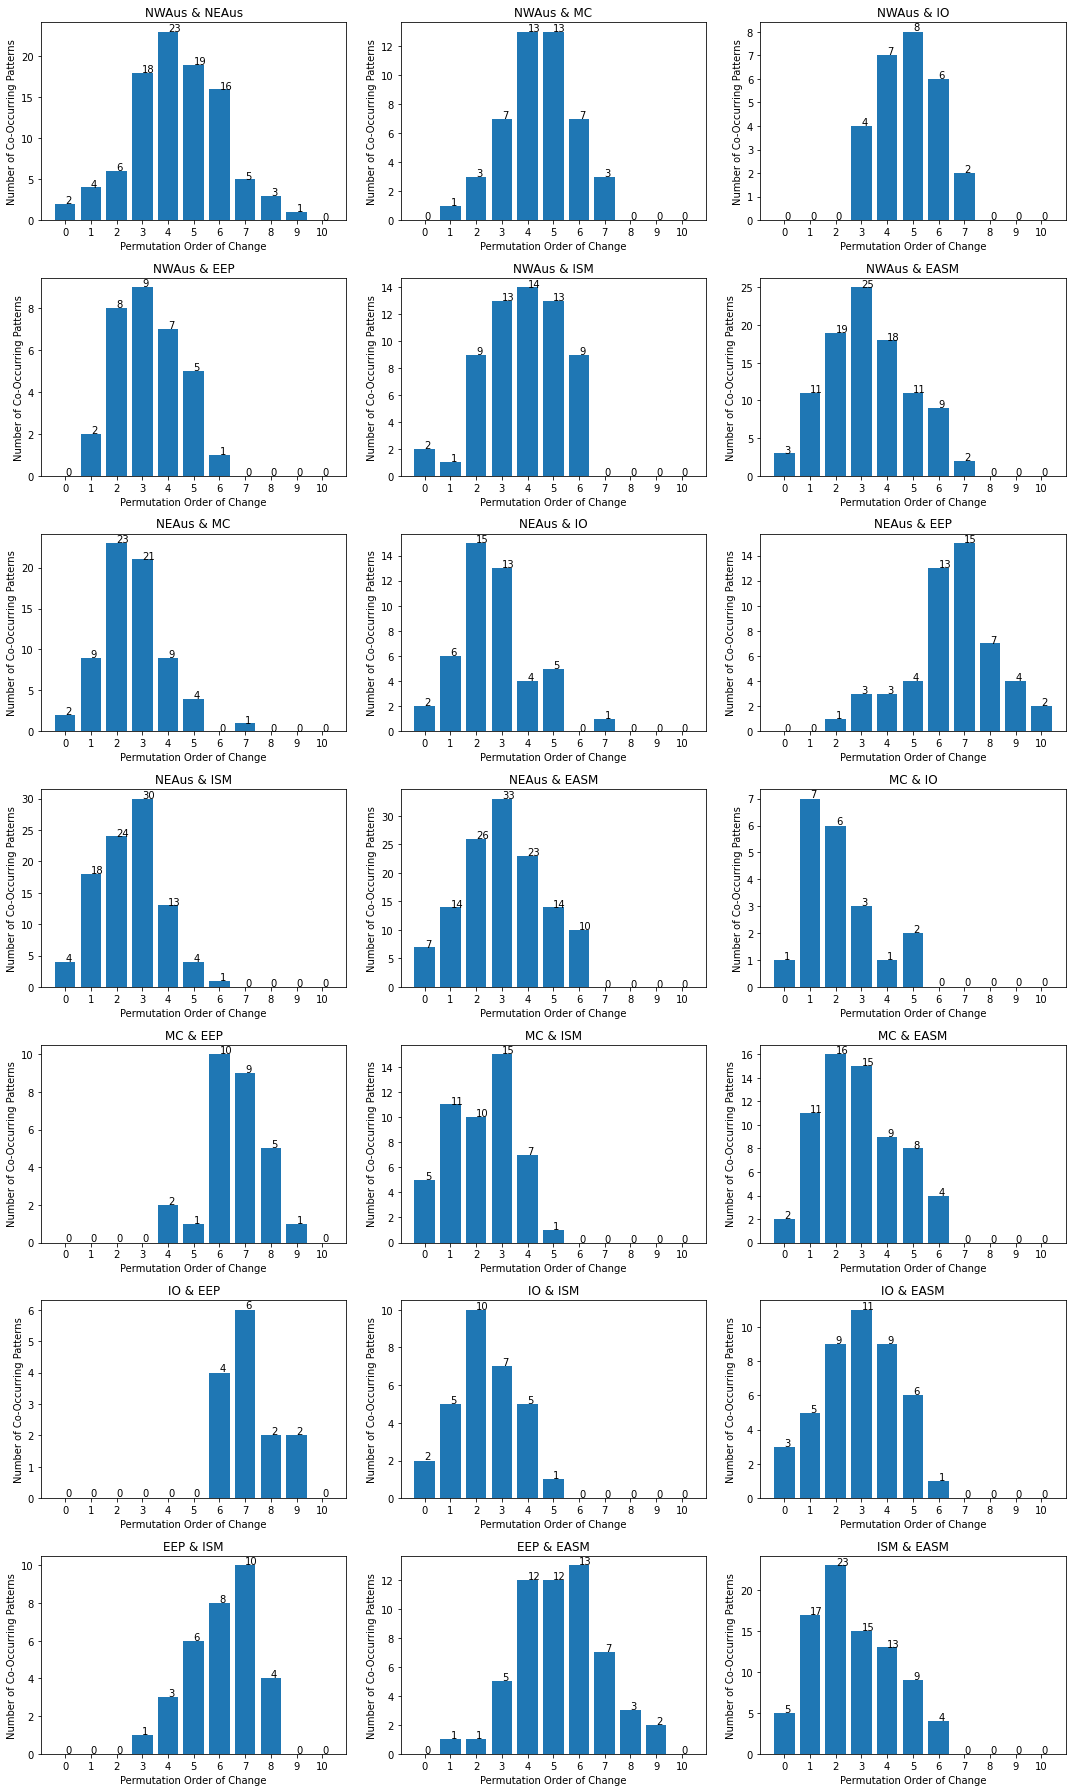

In [41]:
orders = [i for i in range(0,11)]

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15,25))
axs = axs.ravel()
for i in range(len(order_diff_distribution)):
    axs[i].bar(orders,order_diff_distribution[i],tick_label=orders)
    axs[i].set_ylabel('Number of Co-Occurring Patterns')
    axs[i].set_xlabel('Permutation Order of Change')
    axs[i].set_title(permutation_names[i])
    for j, v in enumerate(order_diff_distribution[i]):
        axs[i].text(orders[j], v + 0.05, str(v))
    
fig.tight_layout()